In [2]:
import pandas as pd
import numpy as np
import re
from scipy import interp
import seaborn as sns
import os
import string
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

# NLP Packages
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import nltk
from joblib import dump, load


# ML Models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier

# Scikit Learn packages
from sklearn.base import clone
from sklearn.preprocessing import label_binarize, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import KFold, cross_validate, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, confusion_matrix, f1_score, accuracy_score, classification_report


In [3]:
df = pd.read_csv('Classification.csv')
print(df.shape[0])
df.sample(7)

1297


,Unnamed: 0,Text,Class
197,197,High fuel prices hit BA's profits\n\nBritish A...,business
1087,1087,US TV special for tsunami relief\n\nA US telev...,arts
548,548,Ask Jeeves joins web log market\n\nAsk Jeeves ...,Engineering
422,422,UK young top Euro earnings league\n\nBritish c...,business
694,694,File-swappers ready new network\n\nLegal attac...,Engineering
842,842,Mobile networks seek turbo boost\n\nThird-gene...,Engineering
943,943,Van Gogh festival film withdrawn\n\nMurdered d...,arts


In [28]:
del df["Unnamed: 0"]

KeyError: 'Unnamed: 0'

In [29]:
df.sample(7)

,Text,Class,Text2
1125,Oasis star fined for German brawl\n\nOasis sin...,arts,oasis star fin german brawl oasis singer liam ...
336,Malaysia lifts Islamic bank limit\n\nMalaysia'...,business,malaysia lift islamic bank limit malaysia cent...
266,Worldcom director ends evidence\n\nThe former ...,business,worldcom director end evidence former chief fi...
877,Movie body targets children's PCs\n\nThe body ...,Engineering,movie body target childrens pc body represent ...
360,Amex shares up on spin-off news\n\nShares in A...,business,amex share spinoff news share american express...
380,Tokyo says deflation 'controlled'\n\nThe Japan...,business,tokyo say deflation control japanese governmen...
204,Gold falls on IMF sale concerns\n\nThe price o...,business,gold fall imf sale concern price gold fall int...


In [15]:
df.isna().sum()


Text     0
Class    0
dtype: int64

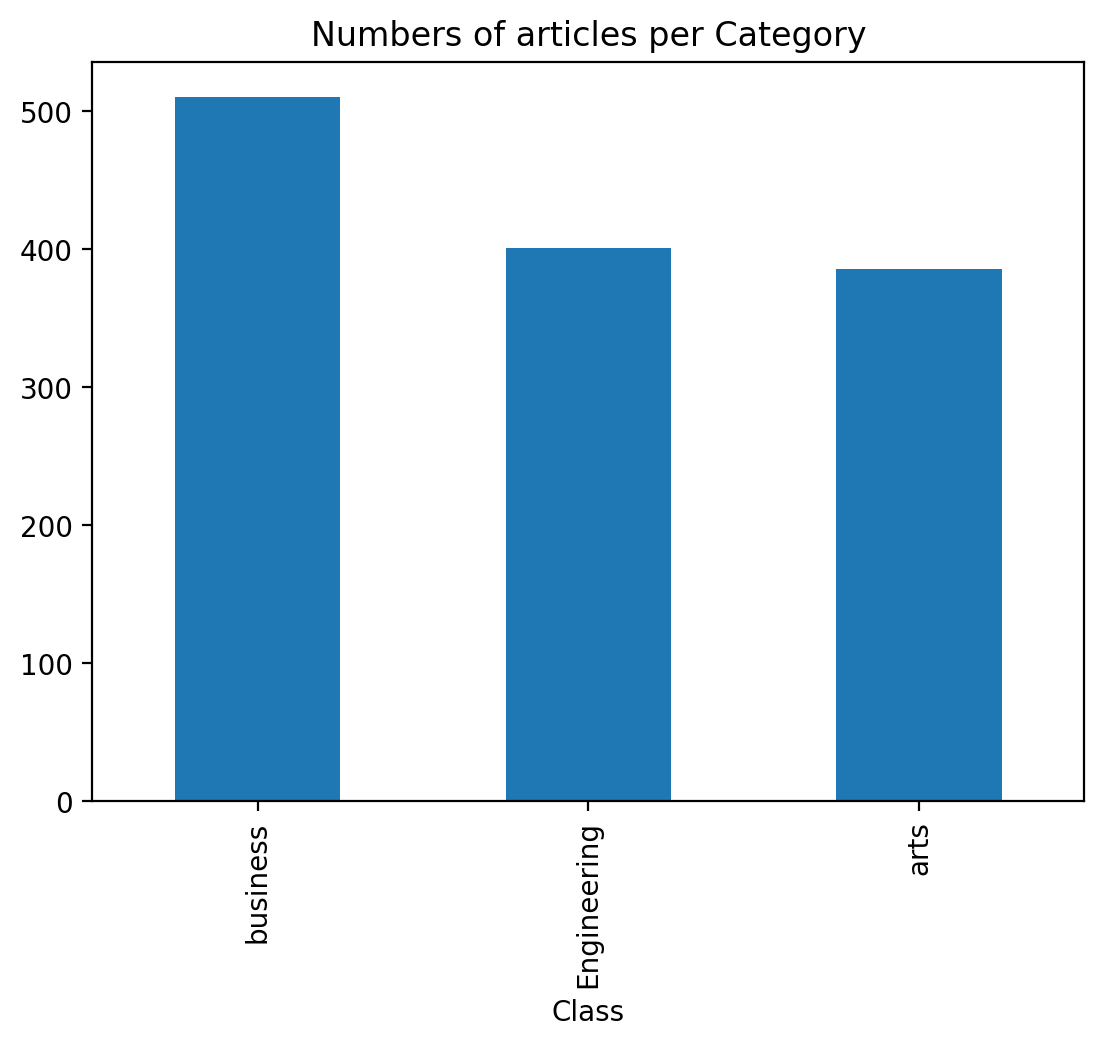

In [14]:
df['Class'].value_counts().plot(kind='bar')
plt.title('Numbers of articles per Category');

In [37]:
def preprocess(df1):
    # Remove special characters
    df1['Text2'] = df1['Text'].replace('\n',' ')
    df1['Text2'] = df1['Text2'].replace('\r',' ')
    
    # Remove punctuation signs and lowercase all
    df1['Text2'] = df1['Text2'].str.lower()
    df1['Text2'] = df1['Text2'].str.translate(str.maketrans('', '', string.punctuation))
    
    
    # Remove stop words
    stop_words = stopwords.words("english")
    lemmatizer = WordNetLemmatizer()
    
    def fwpt(each):
        tag = pos_tag([each])[0][1][0].upper()
        hash_tag = {"N": wordnet.NOUN,"R": wordnet.ADV, "V": wordnet.VERB,"J": wordnet.ADJ}        
        return hash_tag.get(tag, wordnet.NOUN)

    
    def lematize(text):
        tokens = nltk.word_tokenize(text)
        ax = ""
        for each in tokens:
            if each not in stop_words:
                ax += lemmatizer.lemmatize(each, fwpt(each)) + " "
        return ax
    
    df1['Text2'] = df1['Text2'].apply(lematize)
    
    
preprocess(df)    

In [36]:
df['Text2'].sample(5)

206     indonesians face fuel price rise\n\nindonesias...
130     ec calls truce in deficit battle\n\nthe europe...
49      high fuel costs hit us airlines\n\ntwo of the ...
1033    alicia keys to open us super bowl\n\nrb star a...
369     feta cheese battle reaches court\n\na row over...
Name: Text2, dtype: object

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df['Text2'],df['Class'],test_size=0.3,random_state=9)

In [7]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(907,) (390,) (907,) (390,)


In [31]:
y_train

1181           arts
746     Engineering
458        business
1086           arts
1019           arts
           ...     
56         business
501        business
638     Engineering
348        business
382        business
Name: Class, Length: 907, dtype: object

### Vectorize

In [12]:
vector = TfidfVectorizer(stop_words='english', 
                         ngram_range = (1,2),
                         min_df = 3,
                         max_df = 1.,
                         max_features = 10000)

### Model Construction

In [38]:
def fit_model(model, model_name):
    line = Pipeline([('vectorize', vector), (model_name, model)])
    
    output = cross_validate(line, 
                            X_train, 
                            y_train, 
                            cv = KFold(shuffle = True, 
                                       n_splits = 3,  
                                       random_state = 9),
                            scoring = ('accuracy', 'f1_weighted','precision_weighted','recall_weighted'),           
                            return_train_score=True)
    return output

In [39]:
dectree = fit_model(DecisionTreeClassifier(), 'DTree')
ridge = fit_model(RidgeClassifier(), 'Ridge')
bayes = fit_model(MultinomialNB(), 'NB')

dt = pd.DataFrame.from_dict(dectree)
rc = pd.DataFrame.from_dict(ridge)
bc = pd.DataFrame.from_dict(bayes)

In [16]:
l1 = [bc, rc, dt]
l2 =["NB", "Ridge", "DT"]

for each, tag in zip(l1, l2):
    each['model'] = [tag, tag, tag]

joined_output = pd.concat([bc,rc,dt])

In [17]:
relevant_measures = list(['test_accuracy','test_precision_weighted', 'test_recall_weighted', 'test_f1_weighted'])

dec_tree_metrics = joined_output.loc[joined_output.model == 'DT'][relevant_measures]
nb_metrics = joined_output.loc[joined_output.model == 'NB'][relevant_measures]
r_metrics = joined_output.loc[joined_output.model == 'Ridge'][relevant_measures]

In [18]:
dec_tree_metrics

,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted
0,0.858086,0.859237,0.858086,0.858104
1,0.841060,0.843266,0.841060,0.841771
2,0.867550,0.867022,0.867550,0.866893


In [20]:
nb_metrics

,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted
0,0.966997,0.969243,0.966997,0.966922
1,0.966887,0.968029,0.966887,0.967007
2,0.950331,0.951088,0.950331,0.950144


In [21]:
r_metrics

,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted
0,0.983498,0.983999,0.983498,0.983426
1,0.973510,0.973796,0.973510,0.973530
2,0.976821,0.976852,0.976821,0.976819


Multinomial Naive Bayes classifier is chosen to create the final model. Because it has the ability to provide probability score for each prediction it makes, while scoring similarly to the best model.

In [40]:
# Join training and test datasets
X = pd.concat([X_train, 
               X_test])
y = pd.concat([y_train, 
               y_test])

In [41]:
def create_and_fit(clf, x, y):
    best_clf = clf
    pipeline = Pipeline([('vectorize', vector), ('model', best_clf)])
    return pipeline.fit(x, y)

In [42]:
# Create model
CLASSYfier = create_and_fit(MultinomialNB(), X, y)

In [43]:
CLASSYfier.classes_

array(['Engineering', 'arts', 'business'], dtype='<U11')

In [45]:
import tkinter as tk
from tkinter.scrolledtext import ScrolledText

window = tk.Tk()

window.title("CATEGORY CLASSIFIER")
window.minsize(900,500)

text_box = ScrolledText(window)
text_box.grid(column=0, row=1, padx=5, pady=5)

def result(res, pr):
    ENG = round(pr[0][0], 3)
    ARTS = round(pr[0][1], 3)
    BUSINESS = round(pr[0][2], 3)
    
    lines = [f"Arts: {ARTS}", f"Business: {BUSINESS}", f"Engineering: {ENG}"]
    tk.messagebox.showinfo(message= f"Predicted Category: {str(res).capitalize()}" + "\n\n\n"+"\n".join(lines))

def clickMe():
    classification = tk.StringVar()
    category_,probabilities = classify_text(text_box.get("1.0",tk.END))
    result(category_, probabilities)
    

def classify_text(input_text):
    out = CLASSYfier.predict([input_text])[0]
    probs = CLASSYfier.predict_proba([input_text])
    return out,probs

label = tk.Label(window, text = "Enter your text/keywords: ")
label.grid(column = 0, row = 0)

btn = tk.Button(window, text="Please Categorize", command=clickMe)
btn.grid(column=0, row=2)
   

window.mainloop()